# **Ejercicio 1**:

*   Grafique el espacio proyectado de PCA en 2D (etiquetas e imágenes) para los atributos aprendidos por la capa de concatenación.


*   Repita el proceso aplicando la técnica de reducción de dimensión UMAP de RAPIDS.

*   Plantee una nueva arquitectura tipo funcional utilizando capas convolucionales (Ver cuaderno CNNs) para el entrenamiento de la base de datos Mnist-digitos, utilizando tres entradas: i) imágenes limpias, ii) y iii) imágenes con ruido blanco Gaussiano ante diferentes varianzas, y dos salidas i) estimación del digito, ii) estimación número par número impar.





### 📥 Carga y normalización de datos Fashion MNIST

En este bloque se cargan los datos del dataset **Fashion MNIST** utilizando `tf.keras.datasets.fashion_mnist.load_data()`, que contiene imágenes en escala de grises de 28x28 píxeles. Posteriormente, se normalizan los valores de los píxeles al rango [0, 1] para facilitar el entrenamiento de la red neuronal.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar datos Fashion MNIST
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar imágenes a [0, 1]
Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 🧠 Definición del modelo funcional con doble salida

Este bloque construye una arquitectura funcional de red neuronal con Keras que presenta:

- Una **entrada** de imágenes de 28x28 píxeles.
- Un **aplanamiento** (`Flatten`) para convertir la imagen 2D en un vector 1D.
- Una **rama profunda** con dos capas densas ocultas (`Dense`) con activación `tanh`.
- Una **concatenación** entre la salida profunda (`h2`) y la entrada aplanada, permitiendo que la red acceda tanto a características crudas como a representaciones profundas.
- Dos **salidas**:
  - `outputA`: predice una clasificación de 10 clases a partir de la concatenación.
  - `outputB`: predice otra clasificación de 10 clases usando solo la salida profunda.

Esto permite explorar cómo diferentes combinaciones de características afectan la salida.


In [ ]:
# Limpiar sesiones anteriores
tf.keras.backend.clear_session()

# Capa de entrada
input_1 = tf.keras.layers.Input(shape=(28,28), name='entrada')

# Aplanamiento
flatten = tf.keras.layers.Flatten()(input_1)

# Rama profunda
h1 = tf.keras.layers.Dense(200, activation="tanh", name='h1')(flatten)
h2 = tf.keras.layers.Dense(50, activation="tanh", name='h2')(h1)

# Concatenación entre salida profunda y entrada directa
concat = tf.keras.layers.Concatenate(name='concatenate')([h2, flatten])

# Dos salidas
output_A = tf.keras.layers.Dense(10, activation="softmax", name="outputA")(concat)
output_B = tf.keras.layers.Dense(10, activation="softmax", name="outputB")(h2)

# Modelo funcional
model_fun = tf.keras.Model(inputs=input_1, outputs=[output_A, output_B])


### ⚙️ Compilación y entrenamiento del modelo

En esta sección se compila y entrena el modelo funcional definido anteriormente:

- Se utiliza el **optimizador Adam** para minimizar la función de pérdida.
- La **función de pérdida** usada para ambas salidas es `sparse_categorical_crossentropy`, adecuada para clasificación multiclase con etiquetas enteras.
- Se emplea la métrica de **exactitud** (`accuracy`) para ambas salidas.



In [ ]:
# Compilar: una métrica por salida
model_fun.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'accuracy']
)

# Entrenamiento
history = model_fun.fit(
    Xtrain,
    [ytrain, ytrain],  # dos salidas, mismas etiquetas
    epochs=10,
    batch_size=64,
    validation_split=0.3
)


Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.4868 - outputA_accuracy: 0.7320 - outputA_loss: 0.7947 - outputB_accuracy: 0.7615 - outputB_loss: 0.6921 - val_loss: 0.8856 - val_outputA_accuracy: 0.8451 - val_outputA_loss: 0.4385 - val_outputB_accuracy: 0.8406 - val_outputB_loss: 0.4460
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.8098 - outputA_accuracy: 0.8507 - outputA_loss: 0.4109 - outputB_accuracy: 0.8541 - outputB_loss: 0.3990 - val_loss: 0.7878 - val_outputA_accuracy: 0.8527 - val_outputA_loss: 0.3978 - val_outputB_accuracy: 0.8570 - val_outputB_loss: 0.3892
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.7044 - outputA_accuracy: 0.8716 - outputA_loss: 0.3563 - outputB_accuracy: 0.8722 - outputB_loss: 0.3481 - val_loss: 0.7410 - val_outputA_accuracy: 0.8684 - val_outputA_loss: 0.3666 - val_outputB_accuracy: 0.8631 - val_outputB_loss: 0.3732
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6558 - outputA_accuracy: 0.87

### 📊 Proyección PCA de activaciones de la capa `concatenate`

Este bloque realiza un análisis visual del espacio de características aprendido por la red:

- Se crea un **modelo parcial** que llega hasta la capa `concatenate`, extrayendo sus **activaciones** para el conjunto de prueba `Xtest`.
- Luego se aplica **PCA** (Análisis de Componentes Principales) para reducir la dimensionalidad de las activaciones a **2 componentes**.
- Finalmente, se genera un **diagrama de dispersión** coloreado por la etiqueta verdadera de cada muestra, lo que permite visualizar si el modelo ha aprendido representaciones discriminativas para cada clase.


100/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['entrada']
Received: inputs=Tensor(shape=(32, 28, 28))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['entrada']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)


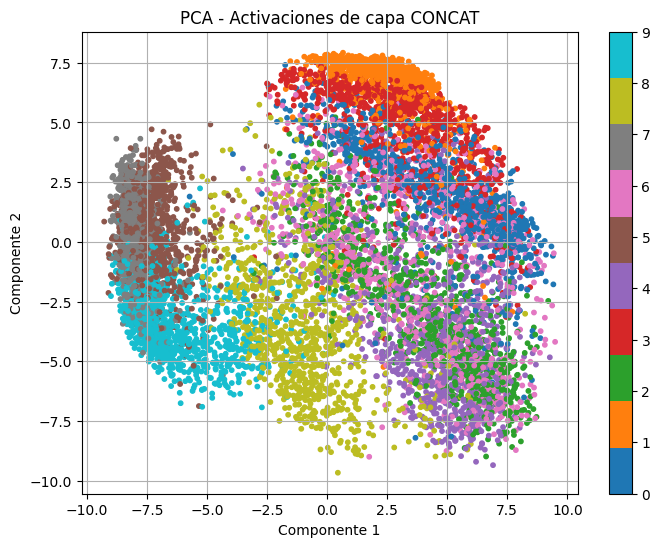

In [ ]:
from sklearn.decomposition import PCA

# Modelo parcial hasta capa 'concatenate'
modelo_concat = tf.keras.Model(
    inputs=model_fun.inputs,
    outputs=model_fun.get_layer('concatenate').output
)

# Activaciones sobre Xtest
z_concat = modelo_concat.predict(Xtest)

# PCA a 2D
zpca_concat = PCA(n_components=2).fit_transform(z_concat)

# Gráfico coloreado por etiquetas
plt.figure(figsize=(8,6))
plt.scatter(zpca_concat[:,0], zpca_concat[:,1], c=ytest, cmap='tab10', s=10)
plt.colorbar()
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA - Activaciones de capa CONCAT')
plt.grid(True)
plt.show()


### 🖼️ Visualización PCA con imágenes reales (Fashion MNIST)

Este bloque permite visualizar las activaciones proyectadas de la capa `concatenate` en el espacio 2D obtenido mediante PCA:



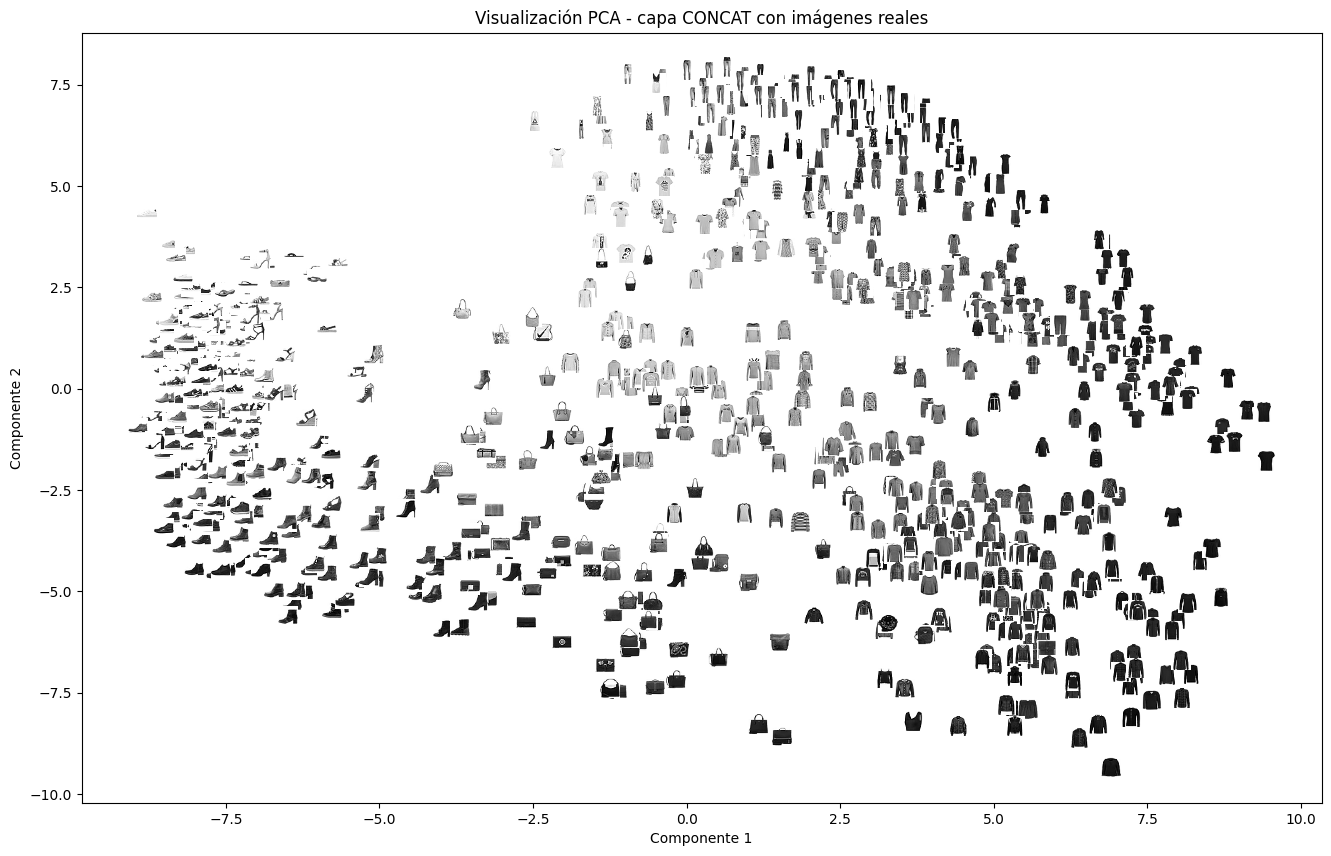

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_mnist_2d(Z, y, images, img_w=28, img_h=28, zoom=0.5, cmap='binary'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom, cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([[Z[i,0], Z[i,1]]])
    ax.autoscale()


N1 = 1000
ind = np.random.randint(0, ytest.shape[0], N1)

plot_mnist_2d(
    zpca_concat[ind],
    ytest[ind],
    Xtest[ind],
    zoom=0.5,
    cmap='binary'
)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("Visualización PCA - capa CONCAT con imágenes reales")
plt.show()


# Planteamiento de modelo CNN

### 📥 Carga y preparación del dataset MNIST

- **Carga el conjunto de datos MNIST** desde Keras. Este dataset contiene imágenes en escala de grises de 28×28 píxeles que representan dígitos manuscritos (0 al 9).
- **Divición manualmente los datos de entrenamiento en dos partes**:
  - `X_train`: primeras 5,000 imágenes para entrenamiento.
  - `X_valid`: últimas 55,000 imágenes para validación.
- **Agrega una dimensión adicional al final de las imágenes** (`[..., np.newaxis]`) para representar el canal (necesario para convoluciones).
- **Normaliza todos los valores de píxeles** dividiendo por 255 para que estén en el rango [0, 1].



In [1]:

# 📚 Librerías base
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 🤖 TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras

# 🧩 Utilidades
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


#Ayuda de código:
#cargar fashion mnist o mnist
#(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]

X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
print(X_train.shape,X_valid.shape,X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


In [2]:
#veector de salida par o impar
ytrain_B = (y_train % 2)
print(ytrain_B[10:])
print(y_train[10:])

[1 1 1 ... 0 1 0]
[3 5 3 ... 2 1 2]


### ➕ Generación de entradas ruidosas

Se crean versiones ruidosas del dataset MNIST agregando ruido blanco Gaussiano con dos varianzas distintas (0.01 y 0.25). Las imágenes se reescalan a [0, 1] y se visualiza un ejemplo.


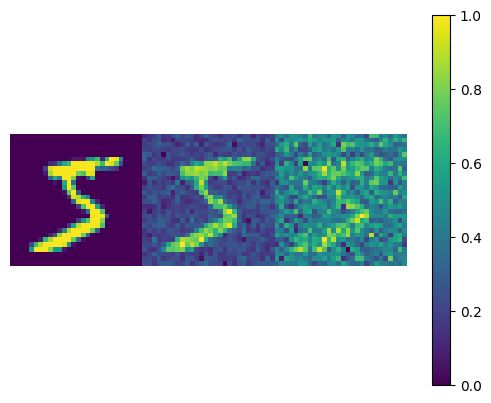

In [3]:
#crear entradas con y sin ruido
from sklearn.preprocessing import MinMaxScaler

var_ = [0.01,0.25]
inputs_train = [X_train]
inputs_valid = [X_valid]
inputs_test = [X_test]

#recorrer varianzas
for var_i in var_:
    dim = X_train.shape
    #definir ruido
    tmp = X_train + (np.sqrt(var_i)*np.random.randn(X_train.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T #fijar señal con ruido de 0 a 1
    inputs_train += [tmp.reshape(dim)]

    dim = X_valid.shape
    tmp = X_valid + (np.sqrt(var_i)*np.random.randn(X_valid.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_valid += [tmp.reshape(dim)]

    dim = X_test.shape
    tmp = X_test + (np.sqrt(var_i)*np.random.randn(X_test.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_test += [tmp.reshape(dim)]


plt.imshow(np.c_[inputs_train[0][0,:,:,0],inputs_train[1][0,:,:,0],inputs_train[2][0,:,:,0]])
plt.axis('off')
plt.colorbar()
plt.show()

### 🧠 Arquitectura funcional CNN multientrada

Se define una red neuronal funcional con tres entradas (imagen limpia y dos ruidosas), cada una procesada por una rama CNN. Las salidas son: clasificación del dígito (10 clases) y par/impar (binaria).


In [4]:
# Reiniciar sesión y definir entradas
tf.keras.backend.clear_session()

# Entradas para imágenes limpias y con ruido (ya normalizadas a [0,1])
input_1 = tf.keras.layers.Input(shape=(28, 28, 1), name='input_clean')
input_2 = tf.keras.layers.Input(shape=(28, 28, 1), name='input_noise_low')
input_3 = tf.keras.layers.Input(shape=(28, 28, 1), name='input_noise_high')

# Definir una función que aplique la misma CNN a una entrada
def cnn_branch(x, name_prefix='cnn'):
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation='relu', name=name_prefix+"_conv1")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, name=name_prefix+"_pool1")(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation='relu', name=name_prefix+"_conv2")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, name=name_prefix+"_pool2")(x)
    x = tf.keras.layers.Flatten(name=name_prefix+"_flatten")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name=name_prefix+"_dense")(x)
    return x

# Aplicar la CNN a cada entrada
branch_1 = cnn_branch(input_1, "cnn1")
branch_2 = cnn_branch(input_2, "cnn2")
branch_3 = cnn_branch(input_3, "cnn3")

# Concatenar características aprendidas
concat = tf.keras.layers.Concatenate(name="concat")([branch_1, branch_2, branch_3])

# Primera salida: clasificación multiclase (dígito)
output_d = tf.keras.layers.Dense(64, activation='relu')(concat)
output_d = tf.keras.layers.Dense(10, activation="softmax", name='output_digit')(output_d)

# Segunda salida: clasificación binaria (par/impar)
output_p = tf.keras.layers.Dense(32, activation='relu')(concat)
output_p = tf.keras.layers.Dense(1, activation="sigmoid", name='output_parity')(output_p)

# Crear el modelo funcional
model_cnn_multi = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output_d, output_p])

# Resumen
model_cnn_multi.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_clean         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_noise_low     │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_noise_high    │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_conv1 (Conv2D) │ (None, 28, 28,    │        320 │ input_clean[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_conv1 (Conv2D) │ (None, 28, 28,    │        320 │ input_noise_low[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn3_conv1 (Conv2D) │ (None, 28, 28,    │        320 │ input_noise_high… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_pool1          │ (None, 14, 14,    │          0 │ cnn1_conv1[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool1          │ (None, 14, 14,    │          0 │ cnn2_conv1[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn3_pool1          │ (None, 14, 14,    │          0 │ cnn3_conv1[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_conv2 (Conv2D) │ (None, 14, 14,    │     18,496 │ cnn1_pool1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_conv2 (Conv2D) │ (None, 14, 14,    │     18,496 │ cnn2_pool1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn3_conv2 (Conv2D) │ (None, 14, 14,    │     18,496 │ cnn3_pool1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_pool2          │ (None, 7, 7, 64)  │          0 │ cnn1_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool2          │ (None, 7, 7, 64)  │          0 │ cnn2_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn3_pool2          │ (None, 7, 7, 64)  │          0 │ cnn3_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_flatten        │ (None, 3136)      │          0 │ cnn1_pool2[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_flatten        │ (None, 3136)      │          0 │ cnn2_pool2[0][0]

 Total params: 1,298,699 (4.95 MB)

 Trainable params: 1,298,699 (4.95 MB)

 Non-trainable params: 0 (0.00 B)



### ⚙️ Compilación y entrenamiento del modelo CNN

Se compila el modelo con dos funciones de pérdida (multiclase y binaria) y se entrena con imágenes limpias y ruidosas durante 10 épocas. Se evalúan ambas salidas: predicción del dígito y par/impar.


In [5]:
# Compilación con dos salidas
model_cnn_multi.compile(
    optimizer='adam',
    loss={
        'output_digit': 'sparse_categorical_crossentropy',
        'output_parity': 'binary_crossentropy'
    },
    metrics={
        'output_digit': 'accuracy',
        'output_parity': 'accuracy'
    }
)

# Entrenamiento
history = model_cnn_multi.fit(
    x=inputs_train,
    y=[y_train, ytrain_B],
    validation_data=(inputs_valid, [y_valid, y_valid % 2]),
    epochs=10,
    batch_size=64
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 1.9123 - output_digit_accuracy: 0.5490 - output_digit_loss: 1.4213 - output_parity_accuracy: 0.7303 - output_parity_loss: 0.4906 - val_loss: 0.5102 - val_output_digit_accuracy: 0.8945 - val_output_digit_loss: 0.3354 - val_output_parity_accuracy: 0.9346 - val_output_parity_loss: 0.1746
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.3536 - output_digit_accuracy: 0.9315 - output_digit_loss: 0.2250 - output_parity_accuracy: 0.9537 - output_parity_loss: 0.1285 - val_loss: 0.2882 - val_output_digit_accuracy: 0.9436 - val_output_digit_loss: 0.1919 - val_output_parity_accuracy: 0.9662 - val_output_parity_loss: 0.0962
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1909 - output_digit_accuracy: 0.9662 - output_digit_loss: 0.1218 - output_parity_accuracy: 0.9755 - output_parity_loss: 0.0690 - val_loss: 0.2226 - val_output_digit_accuracy: 0.9537 - val_output_digit_loss: 0.1518 - val_output_parity_accuracy: 0.

### 📈 Visualización del desempeño del modelo

Se grafican las curvas de **accuracy** y **loss** para ambas salidas (dígito y par/impar) durante el entrenamiento, tanto para entrenamiento como validación.


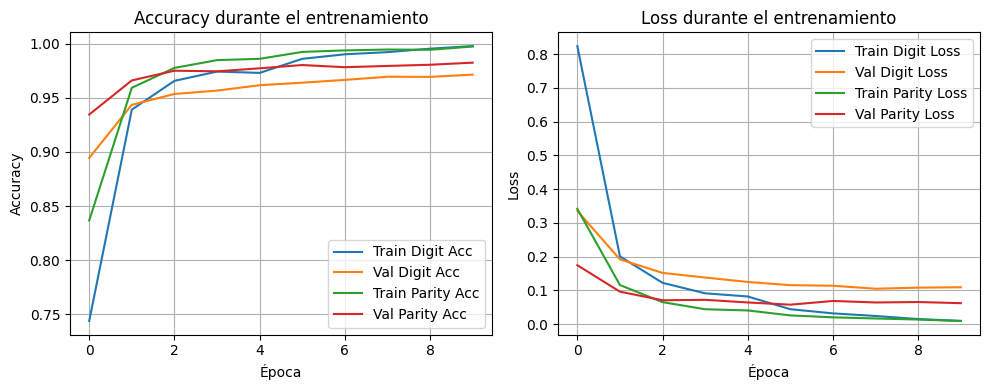

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertimos el historial a DataFrame
hist_df = pd.DataFrame(history.history)

# Gráfico de accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_df["output_digit_accuracy"], label="Train Digit Acc")
plt.plot(hist_df["val_output_digit_accuracy"], label="Val Digit Acc")
plt.plot(hist_df["output_parity_accuracy"], label="Train Parity Acc")
plt.plot(hist_df["val_output_parity_accuracy"], label="Val Parity Acc")
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Gráfico de loss
plt.subplot(1, 2, 2)
plt.plot(hist_df["output_digit_loss"], label="Train Digit Loss")
plt.plot(hist_df["val_output_digit_loss"], label="Val Digit Loss")
plt.plot(hist_df["output_parity_loss"], label="Train Parity Loss")
plt.plot(hist_df["val_output_parity_loss"], label="Val Parity Loss")
plt.title("Loss durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



### 📊 Evaluación del modelo y visualización de resultados

Se evalúa el rendimiento del modelo sobre el conjunto de test. Se muestran predicciones visuales, matriz de confusión para la clasificación de dígitos y curva ROC para la clasificación par/impar.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


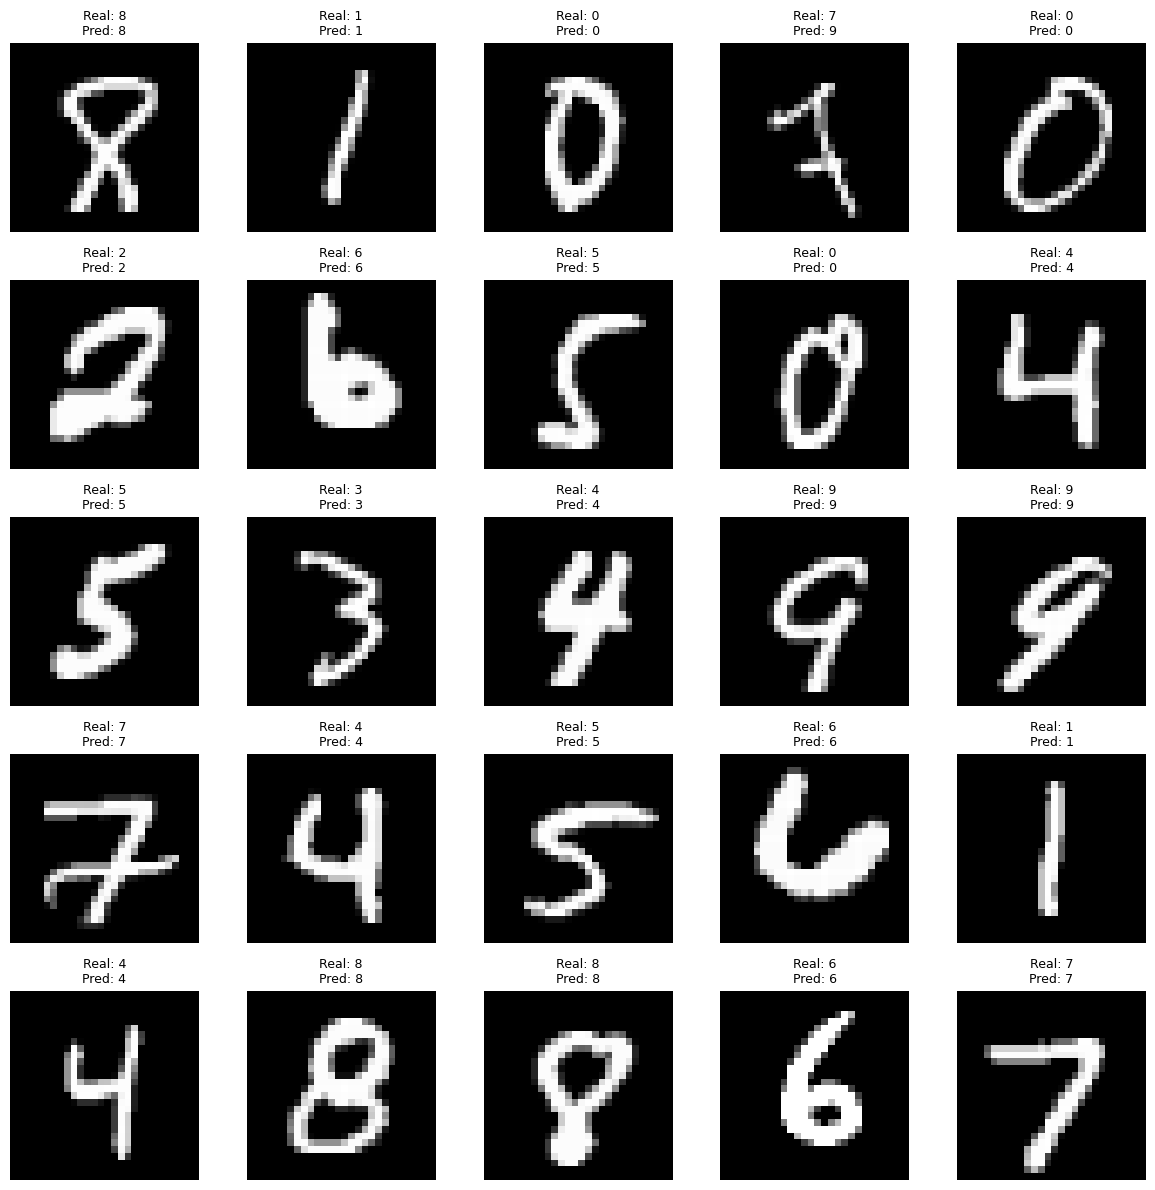

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1551 - output_digit_accuracy: 0.9698 - output_digit_loss: 0.1030 - output_parity_accuracy: 0.9846 - output_parity_loss: 0.0522

loss: 0.1437

compile_metrics: 0.0905

output_digit_loss: 0.0529

output_parity_loss: 0.9749


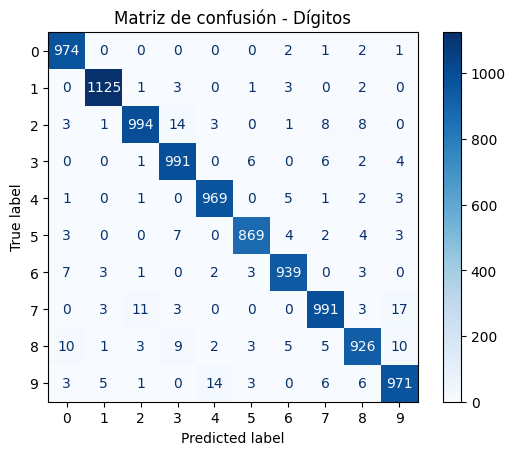

-----------------------------------------------------------------------


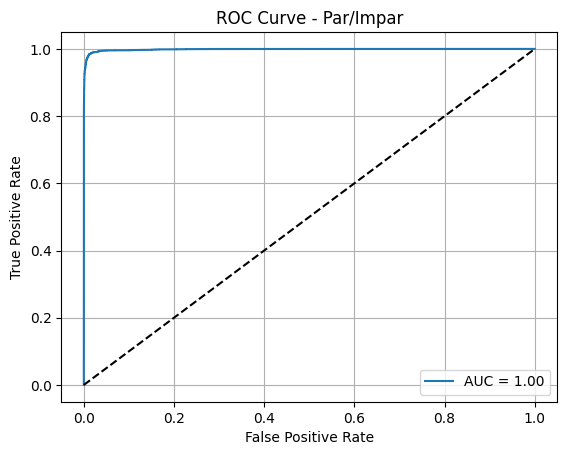

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Predicciones sobre el conjunto de prueba
pred_digit_probs, pred_parity_probs = model_cnn_multi.predict(inputs_test)
pred_digit_labels = np.argmax(pred_digit_probs, axis=1)
true_parity = y_test % 2

# 🔍 Mostrar imágenes con predicciones
n_rows, n_cols = 5, 5
indices = np.random.choice(len(y_test), n_rows * n_cols, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(inputs_test[0][idx, :, :, 0], cmap="gray")
    plt.title(f"Real: {y_test[idx]}\nPred: {pred_digit_labels[idx]}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Evaluar el modelo en todos los datos de test
test_scores = model_cnn_multi.evaluate(inputs_test, [y_test, y_test % 2], verbose=1)

# Mostrar los nombres de las métricas
for name, value in zip(model_cnn_multi.metrics_names, test_scores):
      print(f"\n{name}: {value:.4f}")

# 📉 Matriz de confusión
cm = confusion_matrix(y_test, pred_digit_labels)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Matriz de confusión - Dígitos")
plt.grid(False)
plt.show()

print("-----------------------------------------------------------------------")
# 📈 Curva ROC para clasificación par/impar
fpr, tpr, _ = roc_curve(true_parity, pred_parity_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Par/Impar")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
